# Contextual Retrieval for Multimodal RAG with Azure AI Search and Azure OpenAI in LlamaIndex

## Introduction

In this notebook, we'll demonstrate how to build a contextual retrieval multimodal Retrieval-Augmented Generation (RAG) pipeline using Azure AI Search and Azure OpenAI in LlamaIndex.

We'll walk through the following steps:

1. **Setup:** Install necessary packages and set up credentials.
2. **Load and Parse Document:** Download and parse a PDF document into text and images.
3. **Create Text Nodes with Contextual Metadata:** Generate contextual summaries for each text chunk.
4. **Map Metadata to Azure AI Search Schema:** Define how metadata fields correspond to Azure AI Search fields.
5. **Initialize Azure AI Search Vector Store:** Set up the vector store with the appropriate schema.
6. **Index Documents into Azure AI Search:** Index the text nodes with metadata into Azure AI Search.
7. **Build Multimodal Query Engine:** Create a query engine that can handle text and images.
8. **Perform Queries:** Execute queries and observe how contextual retrieval improves the results.

This notebook is designed for beginners and provides detailed explanations and comments throughout.

## Prerequisites
1. An Azure account with access to Azure AI Search and Azure OpenAI services.
2. API keys and endpoints for both services.
3. Python environment with necessary packages installed.

## 1.Setup
### 1.1 Install Required Packages
First, we need to install the required Python packages. Run the following commands in your terminal or uncomment and run them in your notebook if necessary.

In [ ]:
# Install necessary packages
# !pip install llama-index
# !pip install wget
# !pip install llama-index-vector-stores-azureaisearch
# !pip install azure-search-documents 
# !pip install llama-index-embeddings-azure-openai
# !pip install llama-index-llms-azure-openai
# !pip install llama-index-multi-modal-llms-azure-openai
# !pip install openai
# !pip install nest_asyncio

In [100]:
# Display the version of each installed package
!pip show llama-index | findstr Version
!pip show wget | findstr Version
!pip show llama-index-vector-stores-azureaisearch | findstr Version
!pip show azure-search-documents | findstr Version
!pip show llama-index-embeddings-azure-openai | findstr Version
!pip show llama-index-llms-azure-openai | findstr Version
!pip show llama-index-multi-modal-llms-azure-openai | findstr Version
!pip show openai | findstr Version
!pip show nest_asyncio | findstr Version

Version: 0.11.17
Version: 3.2
Version: 0.2.2
Version: 11.5.1
Version: 0.2.5
Version: 0.2.1
Version: 0.2.0
Version: 1.45.0
Version: 1.6.0


### 1.2 Import Libraries
Now, let's import the necessary libraries.

In [102]:
# Initial Setup: Load environment variables and initialize services
import os
import json
import time
import logging
from copy import deepcopy
from dotenv import load_dotenv
import nest_asyncio
from typing import Optional

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient

from llama_index.core import StorageContext, VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.schema import TextNode, ImageNode, NodeWithScore, MetadataMode
from llama_index.core.settings import Settings
from llama_index.core.query_engine import CustomQueryEngine, SimpleMultiModalQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement, MetadataIndexFieldType


# Apply nest_asyncio to avoid asyncio errors in notebooks
nest_asyncio.apply()

### 1.3 Set Up Azure Credentials
Replace the placeholders with your Azure OpenAI and Azure AI Search credentials.

In [103]:
# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "llamaindex-multimodal-contextual-retreival"

### 1.4 Initialize LLM and Embedding Models and Azure AI Search client


In [104]:
# Initialize Azure OpenAI models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-06-01"
)

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


### 1.5 Setup Observability with Arize Phoenix 

In [ ]:
# Phoenix can display in real time the traces automatically
# collected from your LlamaIndex application.
# Run all of your LlamaIndex applications as usual and traces
# will be collected and displayed in Phoenix.

import phoenix as px

# Look for a URL in the output to open the App in a browser.
px.launch_app()
# The App is initially empty, but as you proceed with the steps below,
# traces will appear automatically as your LlamaIndex application runs.

import llama_index.core

llama_index.core.set_global_handler("arize_phoenix")
...

## 2. Load and Parse the Document
### 2.1 Download the ICONIQ AI Report
We'll use the State of AI Report October 2024
[STATE OF THE AI OCTOBER 2024 REPORT](https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/edit).

Or, you can download the slide deck and just put in a folder path locally (note, the file is large so add it to your .gitignore)

In [107]:
import os
import requests

# Create directories to store data
os.makedirs('data', exist_ok=True)
os.makedirs('data_images_state_of_ai_2024', exist_ok=True)

# Google Slides export link
export_link = "https://docs.google.com/presentation/d/1GmZmoWOa2O92BPrncRcTKa15xvQGhq7g4I4hJSNlC0M/export/pptx"

# Download the PPT report
response = requests.get(export_link)
with open('data/pptx/state-of-ai.pptx', 'wb') as file:
    file.write(response.content)

### 2.2 Parse the Document Using LlamaParse
We'll parse the PDF into text and images using `LlamaParse`. Note that using `LlamaParse` with premium mode may incur costs.

In [ ]:
from llama_parse import LlamaParse

# Initialize LlamaParse
parser = LlamaParse(
    result_type="markdown",
    premium_mode=True
)

# Parse the PDF document
print(f"Parsing text...")
md_json_objs = parser.get_json_result("data/pptx/state-of-ai.pptx")
md_json_list = md_json_objs[0]["pages"]

# Optionally, extract images
image_dicts = parser.get_images(md_json_objs, download_path="data_images_state_of_ai_report_2024")

In [111]:
print(md_json_list[10]["md"])

Introduction | **Research** | Industry | Politics | Safety | #stateofai |
Predictions

# Section 1: Research

stateof.ai


## 3. Build Multimodal Index
We will build a multimodal index over the parsed document by creating text nodes that contain metadata referencing the original image paths.

### 3.1 Get Text Nodes
We'll create TextNode objects from the parsed markdown data, attaching metadata such as page numbers and image paths.

In [113]:
import re
from copy import deepcopy
from pathlib import Path

def get_page_number(file_name):
    match = re.search(r"-page_(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0

def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [
        f for f in list(Path(image_dir).iterdir()) if f.is_file() and "-page" in str(f)
    ]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

# Attach image metadata to the text nodes
def get_text_nodes(image_dir, json_dicts):
    """Create TextNodes with metadata including image paths and doc_id."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir)
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        # Assign a unique doc_id for each text node
        doc_id = f"doc_{idx+1}"  # Can be a string or an integer

        # Add doc_id to the metadata
        chunk_metadata = {
            "page_num": idx + 1,
            "image_path": str(image_files[idx]),
            "parsed_text_markdown": md_texts[idx],
        }

        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes


# Create text nodes
text_nodes = get_text_nodes(image_dir="data_images_state_of_ai_report_2024", json_dicts=md_json_list)

# Print an example node
print(text_nodes[0].get_content(metadata_mode="all"))


page_num: 1
image_path: data_images_state_of_ai_report_2024\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_1.jpg
parsed_text_markdown: # STATE OF AI REPORT

October 10, 2024

Nathan Benaich

## AIR STREET CAPITAL

stateof                              airstreet.


### 3.2 Add Contextual Summaries
We implement the key step in contextual retrieval by attaching metadata to each chunk that situates it within the overall document context.

In [ ]:
from llama_index.core.schema import MetadataMode
from copy import deepcopy
from llama_index.core.llms import ChatMessage
import time

# Prepare prompts for contextual summaries
whole_doc_text = """\
Here is the entire document.
<document>
{WHOLE_DOCUMENT}
</document>"""

chunk_text = """\
Here is the chunk we want to situate within the whole document
<chunk>
{CHUNK_CONTENT}
</chunk>
Please give a short succinct context to situate this chunk within the overall document for \
the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else."""

# Modify the function that creates contextual nodes so that they are well incorporated in embedding
def create_contextual_nodes(nodes, llm):
    """Function to create contextual nodes with added context."""
    nodes_modified = []

    # Get overall document text
    doc_text = "\n".join([n.get_content(metadata_mode=MetadataMode.ALL) for n in nodes])

    for idx, node in enumerate(nodes):
        start_time = time.time()
        new_node = deepcopy(node)

        # Messages to generate contextual summary
        messages = [
            ChatMessage(role="system", content="You are a helpful AI Assistant."),
            ChatMessage(
                role="user",
                content=[
                    {
                        "text": whole_doc_text.format(WHOLE_DOCUMENT=doc_text),
                        "type": "text",
                        "cache_control": {"type": "ephemeral"},
                    },
                    {
                        "text": chunk_text.format(
                            CHUNK_CONTENT=node.get_content(metadata_mode=MetadataMode.ALL)
                        ),
                        "type": "text",
                    },
                ],
            ),
        ]

        # Generate contextual summary
        new_response = llm.chat(messages)
        new_node.metadata["context"] = str(new_response)

        nodes_modified.append(new_node)
        print(f"Completed node {idx}, {time.time() - start_time}")

    return nodes_modified

# Create contextual text nodes with context incorporated
new_text_nodes = create_contextual_nodes(text_nodes, llm)

# Print to verify that context is included in metadata
print(new_text_nodes[0].metadata)

In [118]:
new_text_nodes[0]

TextNode(id_='a4f01576-c45a-4071-854b-cc174cc4ac87', embedding=None, metadata={'page_num': 1, 'image_path': 'data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_1.jpg', 'parsed_text_markdown': '# STATE OF AI REPORT\n\nOctober 10, 2024\n\nNathan Benaich\n\n## AIR STREET CAPITAL\n\nstateof                              airstreet.', 'context': 'assistant: This chunk serves as the title page of the "State of AI Report 2024," authored by Nathan Benaich and published by Air Street Capital. It introduces the report, which compiles insights and analyses on the current state and future predictions of artificial intelligence across various dimensions, including research, industry, politics, and safety.'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

## 4. Build Index with Azure AI Search
We will now build two indexes with Azure AI Search. The first will be our Contextual Summary index and the other will be a Standard (Baseline) index to compare later.
### 4.1 Index contextual summary nodes 

In [ ]:
# --- Indexing Part (modified to bypass LlamaIndex Documents) ---

# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
    "context": (
        "context",
        MetadataIndexFieldType.STRING,
    ),  # Only used for contextual index
}

# --- Contextual Retrieval Index ---

# Set this to True if you want to use an existing index, False to create a new one
use_existing_index = True

# Create the Azure AI Search vector store for contextual retrieval
if use_existing_index:
    contextual_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-contextual-retrieval",
        index_management=IndexManagement.VALIDATE_INDEX,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,  # Based on embedding model
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )
else:
    contextual_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-contextual-retrieval",
        index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,  # Based on embedding model
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

# Load documents and create index based on the use_existing_index flag
if use_existing_index:
    contextual_storage_context = StorageContext.from_defaults(
        vector_store=contextual_vector_store
    )
    contextual_index = VectorStoreIndex(
        storage_context=contextual_storage_context,
    )
else:
    # Load documents
    contextual_storage_context = StorageContext.from_defaults(
        vector_store=contextual_vector_store
    )

    # Create index using `new_text_nodes` directly
    contextual_index = VectorStoreIndex(
        new_text_nodes,  # Use the text nodes with contextual embeddings
        storage_context=contextual_storage_context,
        embed_model=embed_model,
        llm=llm,
        show_progress=True,
    )

### 4.2 Build Baseline Index
We will also build a baseline index with the text nodes without contextual summaries for comparison.

In [ ]:
# Define metadata fields mapping
metadata_fields = {
    "page_num": ("page_num", MetadataIndexFieldType.INT64),
    "image_path": ("image_path", MetadataIndexFieldType.STRING),
    "parsed_text_markdown": ("parsed_text_markdown", MetadataIndexFieldType.STRING),
}

# --- Baseline Index ---

# Set this to True if you want to use an existing index, False to create a new one
use_existing_index = True

# Create the Azure AI Search vector store for baseline retrieval
if use_existing_index:
    baseline_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-standard",
        index_management=IndexManagement.VALIDATE_INDEX,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )
else:
    baseline_vector_store = AzureAISearchVectorStore(
        search_or_index_client=index_client,
        index_name="llamaindex-multimodal-standard",
        index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
        id_field_key="id",
        chunk_field_key="parsed_text_markdown",
        embedding_field_key="embedding",
        embedding_dimensionality=1536,
        metadata_string_field_key="metadata",
        doc_id_field_key="doc_id",
        filterable_metadata_field_keys=metadata_fields,
        language_analyzer="en.lucene",
        vector_algorithm_type="exhaustiveKnn",
    )

# Load documents and create index based on the use_existing_index flag
if use_existing_index:
    baseline_storage_context = StorageContext.from_defaults(vector_store=baseline_vector_store)
    baseline_index = VectorStoreIndex.from_documents(
        [],
        storage_context=baseline_storage_context,
    )
else:
    # Load documents
    baseline_storage_context = StorageContext.from_defaults(vector_store=baseline_vector_store)

    # Create index
    baseline_index = VectorStoreIndex(
        nodes=text_nodes,
        storage_context=baseline_storage_context,
        embed_model=embed_model,
        llm=llm,
        show_progress=True,
    )

## 6. Build Multimodal Query Engine
We will build a custom multimodal query engine that can retrieve both text and image data.

In [119]:
from llama_index.core.query_engine import CustomQueryEngine, BaseQueryEngine
from llama_index.core.retrievers import BaseRetriever
from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.core.prompts import PromptTemplate
from llama_index.core.base.response.schema import Response
from typing import Optional

# Initialize AzureOpenAIMultiModal for GPT-4V
azure_openai_mm_llm = AzureOpenAIMultiModal(
    engine="gpt-4o-mini",  # Use GPT-4V (vision model)
    api_version="2024-06-01",
    model="gpt-4o-mini",
    max_new_tokens=4096,
    api_key=AZURE_OPENAI_API_KEY,
    api_base=AZURE_OPENAI_ENDPOINT,
)

QA_PROMPT_TMPL = """\
Below we give parsed text from slides in parsed markdown format, as well as the image.

---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query. Explain whether you got the answer
from the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.

Query: {query_str}
Answer: """

QA_PROMPT = PromptTemplate(QA_PROMPT_TMPL)


class MultimodalQueryEngine(CustomQueryEngine):
    """Custom multimodal Query Engine.

    Takes in a retriever to retrieve a set of document nodes.
    Also takes in a prompt template and multimodal model.

    """

    qa_prompt: PromptTemplate
    retriever: BaseRetriever
    multi_modal_llm: AzureOpenAIMultiModal

    def __init__(self, qa_prompt: Optional[PromptTemplate] = None, **kwargs) -> None:
        """Initialize."""
        super().__init__(qa_prompt=qa_prompt or QA_PROMPT, **kwargs)

    def custom_query(self, query_str: str):
        # retrieve text nodes
        nodes = self.retriever.retrieve(query_str)
        # create ImageNode items from text nodes
        image_nodes = [
            NodeWithScore(node=ImageNode(image_path=n.metadata["image_path"]))
            for n in nodes
        ]

        # create context string from text nodes, dump into the prompt
        context_str = "\n\n".join(
            [r.get_content(metadata_mode=MetadataMode.LLM) for r in nodes]
        )
        fmt_prompt = self.qa_prompt.format(context_str=context_str, query_str=query_str)

        # synthesize an answer from formatted text and images
        llm_response = self.multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=[image_node.node for image_node in image_nodes],
        )
        return Response(
            response=str(llm_response),
            source_nodes=nodes,
            metadata={"text_nodes": nodes, "image_nodes": image_nodes},
        )

        return response

In [136]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode
from llama_index.core import get_response_synthesizer
import pprint

# define response synthesizer
response_synthesizer = get_response_synthesizer()

# Standard Query Engines (Standard Retrieval)
standard_embedding_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

standard_hybrid_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

standard_semantic_hybrid_query_engine = MultimodalQueryEngine(
    retriever=baseline_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

# Contextual Query Engines (Contextual Retrieval)
contextual_embedding_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.DEFAULT, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

contextual_hybrid_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

contextual_semantic_hybrid_query_engine = MultimodalQueryEngine(
    retriever=contextual_index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=3),
    multi_modal_llm=azure_openai_mm_llm,
)

## 7. Try Out Queries
Let's test our multimodal RAG pipeline by asking some questions.
### 7.1 Query Example 1

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



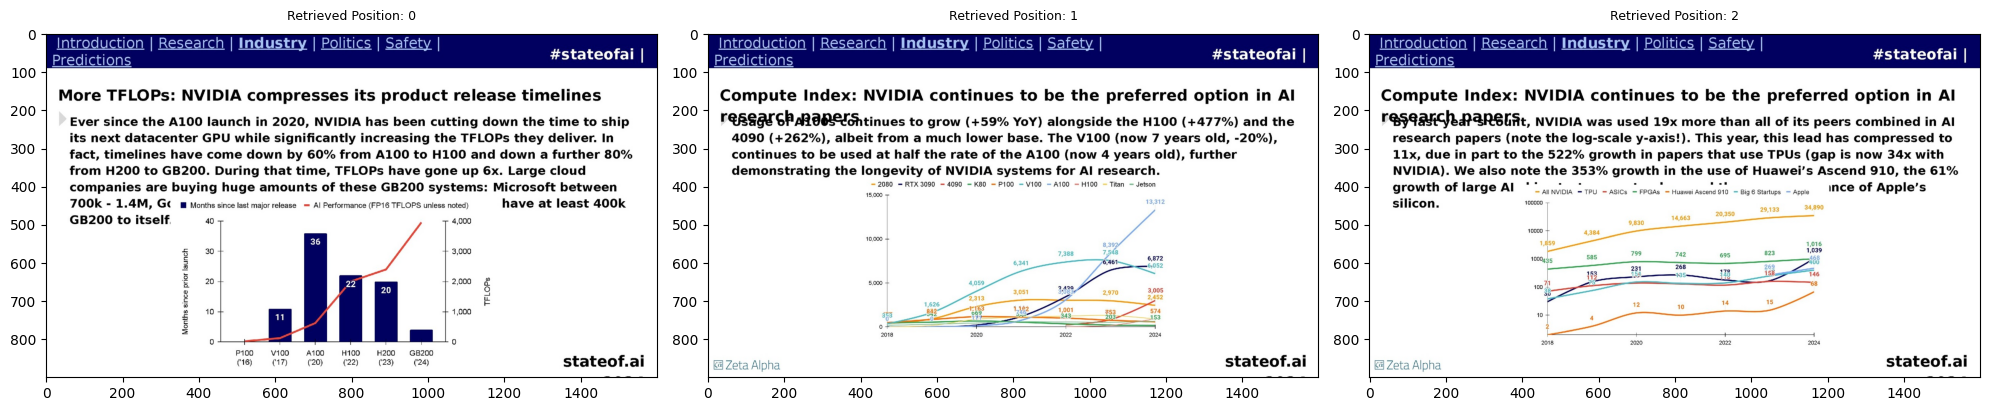

Response: The trends in AI compute efficiency identified in 2024 highlight several key points:

1. **Increased TFLOPs and Reduced Release Timelines**: NVIDIA has significantly compressed the timelines for releasing new datacenter GPUs while increasing their performance. For instance, the time between major releases has decreased by 60% from the A100 to the H100 and by another 80% from the H200 to the GB200. During this period, the performance in TFLOPs has increased sixfold.

2. **Growing Adoption of GPUs**: The usage of NVIDIA GPUs in AI research papers continues to rise, with the A100 showing a 59% year-over-year growth, the H100 at 477%, and the 4090 at 262%. This indicates a strong preference for NVIDIA products in the AI research community.

3. **Comparative Performance**: The performance of inference compute has seen substantial improvements, with the GB200 achieving approximately 4000 FP16 TFLOPS, which is a significant increase compared to previous models like the A100 (600 TFL

In [121]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata


# Query with baseline retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
baseline_response = standard_embedding_query_engine.query(query)

with using_metadata({"engine": "standard_embedding_query_engine"}):
    result_b = standard_embedding_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for standard_embedding_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### 7.2 Query Example 2

Query: What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?
Retrieved Images:



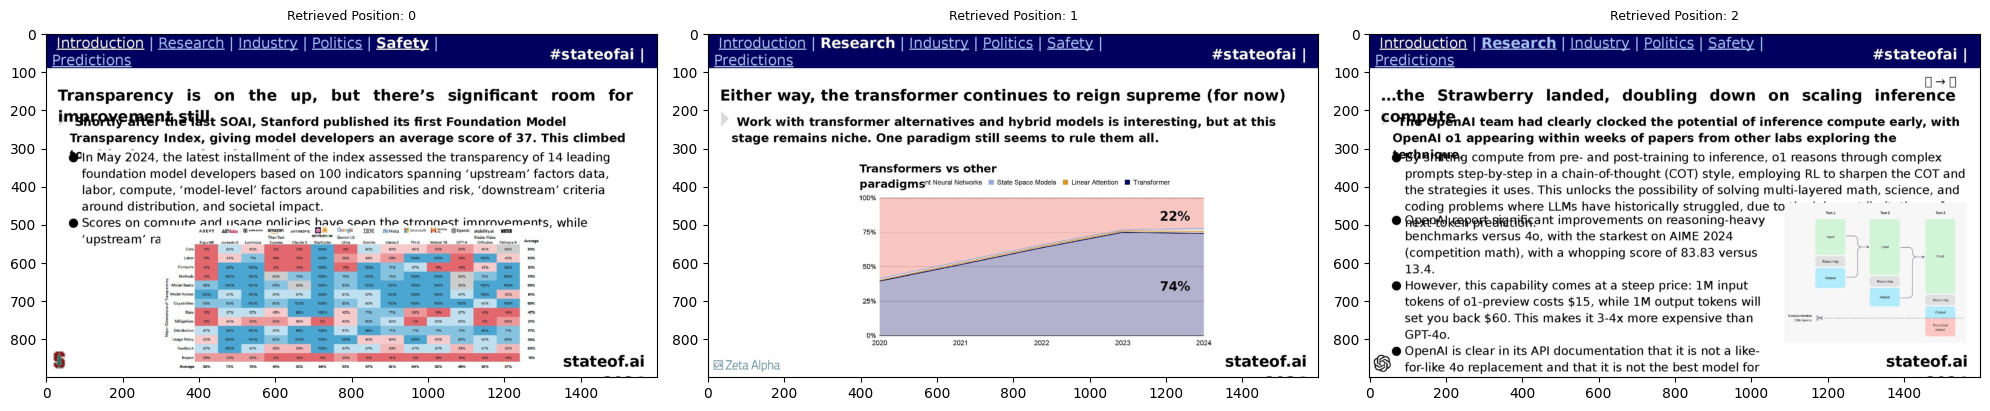

Response: The trends in AI compute efficiency identified in 2024 highlight a significant focus on inference compute, particularly with OpenAI's o1 model. This model shifts compute resources from pre- and post-training to inference, allowing for improved reasoning capabilities through a chain-of-thought (COT) approach. The performance on reasoning-heavy benchmarks has shown marked improvements, with OpenAI reporting a score of 83.83 on the AIME 2024 competition math benchmark, compared to just 13.4 for the previous model (4o).

In terms of cost, the o1 model is significantly more expensive, costing 3-4 times more than GPT-4o, with 1M input tokens priced at $15 and 1M output tokens at $60.

This information was derived from the parsed markdown text, specifically from the section discussing OpenAI's advancements with the o1 model. There were no discrepancies between the parsed markdown and the context provided, as the markdown clearly outlines the trends and performance metrics related to

In [122]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
import os

# Query with contextual retrieval
query = "What trends in AI compute efficiency were identified in 2024, and how does the performance of inference compute compare to previous years?"
contextual_response = contextual_semantic_hybrid_query_engine.query(query)
with using_metadata({"engine": "contextual_semantic_hybrid_query_engine"}):
    result_a = contextual_semantic_hybrid_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for contextual_semantic_hybrid_query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [123]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with standard retreival:")
get_source_page_nums(baseline_response)

print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

Pages retrieved with standard retreival:
96,94,93
Pages retrieved with contextual retrieval:
195,28,13


### 7.3 Query Example 3

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



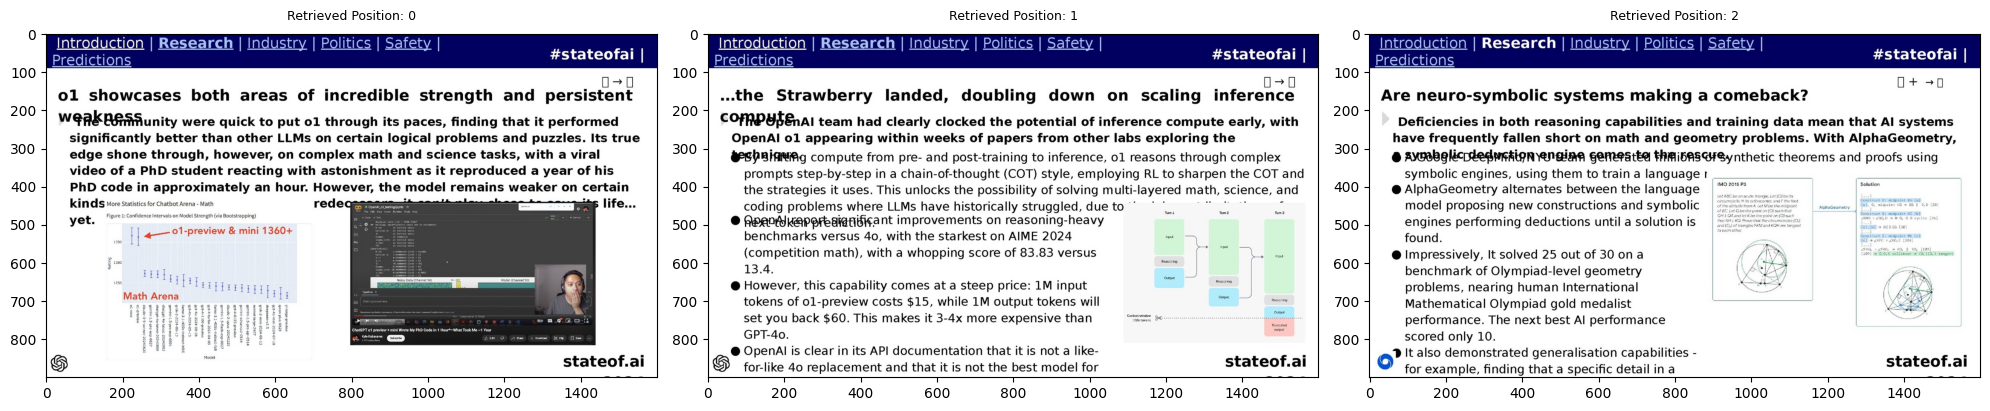

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Strength in Reasoning**: The o1 model has shown significant improvements in reasoning-heavy benchmarks, particularly in complex math and science tasks. It employs a chain-of-thought (COT) reasoning style, which allows it to tackle multi-layered problems effectively.
2. **Performance on Benchmarks**: It achieved a notable score of 83.83 on the AIME 2024 competition math benchmark, indicating a strong performance compared to previous models.

### Limitations:
1. **Spatial Reasoning**: The model struggles with certain types of spatial reasoning tasks. It has been noted that it cannot perform well in games like chess.
2. **Cost**: The operational cost of using the o1 model is significantly higher than its predecessor, GPT-4o, making it 3-4 times more expensive for certain tasks.

This information was derived from the parsed markdown text, 

In [124]:
from llama_index.core.response.notebook_utils import display_response, display_query_and_multimodal_response, display_source_node
from llama_index.core.schema import MetadataMode

# Query with baseline retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
baseline_response = standard_embedding_query_engine.query(query)

with using_metadata({"engine": "standard_embedding_query_engine"}):
    result_b = standard_embedding_query_engine.query(query)
    display_query_and_multimodal_response(query, result_b, 8, 20)
    print("\nSource Nodes for standard_embedding_query_engine:")
    for node in result_b.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

### Query Example 4

Query: What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?
Retrieved Images:



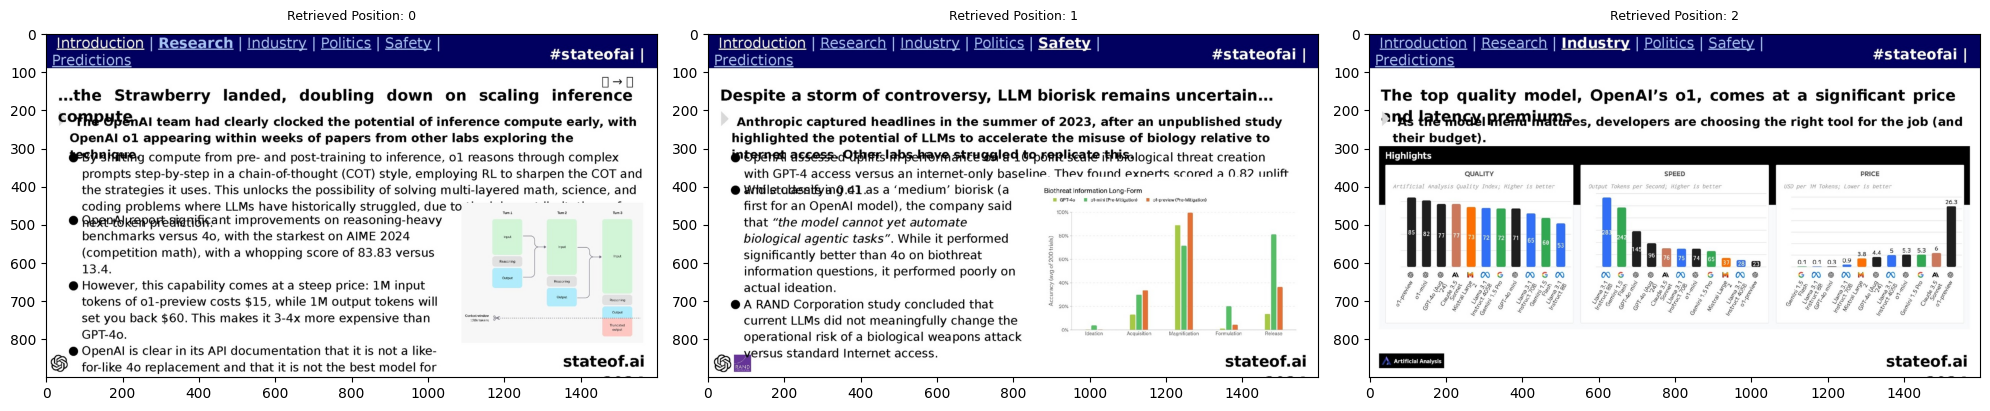

Response: The current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems are as follows:

### Capabilities:
1. **Inference Compute**: The o1 model shifts compute focus from pre- and post-training to inference, allowing it to reason through complex prompts step-by-step using a chain-of-thought (COT) style.
2. **Improved Reasoning**: It employs reinforcement learning (RL) to enhance its reasoning strategies, enabling it to tackle multi-layered math, science, and coding problems more effectively than previous models.
3. **Benchmark Performance**: OpenAI reports significant improvements on reasoning-heavy benchmarks, achieving a score of 83.83 on AIME 2024 (competition math), compared to 13.4 for the previous model (4o).

### Limitations:
1. **Cost**: The model is expensive to use, with 1M input tokens costing $15 and 1M output tokens costing $60, making it 3-4 times more expensive than GPT-4o.
2. **Not a Direct Replacement**: OpenAI clarifies that o

In [125]:
from llama_index.core.response.notebook_utils import display_query_and_multimodal_response
from llama_index.core.schema import MetadataMode
from openinference.instrumentation import using_metadata
import os

# Query with contextual retrieval
query = "What are the current capabilities and limitations of OpenAI's o1 model in solving complex mathematical problems?"
contextual_response = contextual_semantic_hybrid_query_engine.query(query)
with using_metadata({"engine": "contextual_semantic_hybrid_query_engine"}):
    result_a = contextual_semantic_hybrid_query_engine.query(query)
    display_query_and_multimodal_response(query, result_a, 8, 20)
    print("\nSource Nodes for contextual_semantic_hybrid_query_engine:")
    for node in result_a.source_nodes:
        print(node.get_content(metadata_mode=MetadataMode.LLM))

In [126]:
def get_source_page_nums(response):
    page_nums = [str(node.node.metadata.get("page_num", "N/A")) for node in response.source_nodes]
    print(",".join(page_nums))

# Compare source page numbers
print("Pages retrieved with standard retreival:")
get_source_page_nums(baseline_response)

print("Pages retrieved with contextual retrieval:")
get_source_page_nums(contextual_response)

Pages retrieved with standard retreival:
14,13,20
Pages retrieved with contextual retrieval:
13,201,108


## 8. Evaluations with Arize Phoenix
### 8.1 Run Your Query Engine and View Your Traces in Phoenix

In [137]:
from tqdm import tqdm
import json
from openinference.instrumentation import using_metadata
from phoenix.trace import using_project

# Load all evaluation questions from queries.jsonl
eval_questions = []
with open("eval/contextual-queries.jsonl", "r") as file:
    for line in file:
        # Parse each line as JSON and extract the query
        json_line = json.loads(line.strip())
        eval_questions.append(json_line)

# List of query engines and their respective project names
query_engines = [
    (standard_embedding_query_engine, "Standard: Embedding"),
    (standard_hybrid_query_engine, "Standard: Hybrid"),
    (standard_semantic_hybrid_query_engine, "Standard: Hybrid + Rerank"),
    (contextual_embedding_query_engine, "Contextual: Embedding"),
    (contextual_hybrid_query_engine, "Contextual: Hybrid"),
    (contextual_semantic_hybrid_query_engine, "Contextual: Hybrid + Rerank"),
]

# Loop through each question and query it against each engine
for query_data in tqdm(eval_questions):
    query = query_data["query"]
    query_classification = query_data.get("query_classification", "undefined")  # Default to 'undefined' if not present

    for engine, project_name in query_engines:
        try:
            metadata = query_classification
            with using_project(project_name), using_metadata(metadata):
                # Assuming the query method expects a string query and returns results
                engine.query(query)
        except Exception as e:
            print(f"Error querying {project_name} for query '{query}': {e}")





































































































100%|██████████| 10/10 [10:56<00:00, 65.67s/it]


### 8.2 Export and Evaluate Your Trace Data

In [138]:
from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from tqdm import tqdm

# Define the evaluation model
eval_model = OpenAIModel(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_deployment="gpt-4o-mini",  # I'm using gpt-4o-mini for evaluation
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2024-06-01"
)

# Define evaluators
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_correctness_evaluator = QAEvaluator(eval_model)
relevance_evaluator = RelevanceEvaluator(eval_model)

# List of project names corresponding to each query engine
projects = [
    "Standard: Embedding",
    "Standard: Hybrid",
    "Standard: Hybrid + Rerank",
    "Contextual: Embedding",
    "Contextual: Hybrid",
    "Contextual: Hybrid + Rerank",
]

# Loop through each project and perform evaluations
for project in projects:
    # Create queries and retrieved documents DataFrames for the project
    queries_df = get_qa_with_reference(px.Client(), project_name=project)
    retrieved_documents_df = get_retrieved_documents(px.Client(), project_name=project)
    
    # Run evaluations
    hallucination_eval_df, qa_correctness_eval_df = run_evals(
        dataframe=queries_df,
        evaluators=[hallucination_evaluator, qa_correctness_evaluator],
        provide_explanation=True,
    )
    relevance_eval_df = run_evals(
        dataframe=retrieved_documents_df,
        evaluators=[relevance_evaluator],
        provide_explanation=True,
    )[0]
    
    # Log evaluations
    px.Client().log_evaluations(
        SpanEvaluations(eval_name=f"Hallucination_{project}", dataframe=hallucination_eval_df),
        SpanEvaluations(eval_name=f"QA Correctness_{project}", dataframe=qa_correctness_eval_df),
        DocumentEvaluations(eval_name=f"Relevance_{project}", dataframe=relevance_eval_df),
    )


run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

run_evals |          | 0/200 (0.0%) | ⏳ 00:00<? | ?it/s

### 8.3 View Evaluation Results in Arize Phoenix UI


### Query Engine Performance Summary @5

| Retrieval Mode                  | QA Correctness@5 | NDCG@5 | Precision@5 | Hit Rate@5 |
| ------------------------------- | ---------------- | ------ | ----------- | ---------- |
| **Standard: Embedding**          | 1.00             | 0.65   | 0.42        | 0.80       |
| **Standard: Hybrid**             | 0.90             | 0.56   | 0.42        | 0.70       |
| **Standard: Hybrid + Rerank**    | 1.00             | 0.59   | 0.38        | 0.70       |
| **Contextual: Embedding**        | 1.00             | 0.65   | 0.44        | 0.70       |
| **Contextual: Hybrid**           | 1.00             | 0.61   | 0.40        | 0.70       |
| **Contextual: Hybrid + Rerank**  | 1.00             | 0.66   | 0.42        | 0.80       |

### Query Engine Performance Summary @10

| Retrieval Mode                  | QA Correctness@10 | NDCG@10 | Precision@10 | Hit Rate@10 |
| ------------------------------- | ----------------- | ------- | ------------ | ----------- |
| **Standard: Embedding**          | 0.90              | 0.58    | 0.37         | 0.70        |
| **Standard: Hybrid**             | 1.00              | 0.68    | 0.36         | 0.80        |
| **Standard: Hybrid + Rerank**    | 1.00              | 0.58    | 0.34         | 0.70        |
| **Contextual: Embedding**        | 0.90              | 0.63    | 0.42         | 0.70        |
| **Contextual: Hybrid**           | 1.00              | 0.61    | 0.39         | 0.70        |
| **Contextual: Hybrid + Rerank**  | 0.90              | 0.57    | 0.34         | 0.70        |

### Query Engine Performance Summary @20

| Retrieval Mode                  | QA Correctness@20 | NDCG@20 | Precision@20 | Hit Rate@20 |
| ------------------------------- | ----------------- | ------- | ------------ | ----------- |
| **Standard: Embedding**          | 1.00              | 0.59    | 0.33         | 0.80        |
| **Standard: Hybrid**             | 1.00              | 0.62    | 0.31         | 0.80        |
| **Standard: Hybrid + Rerank**    | 1.00              | 0.57    | 0.30         | 0.80        |
| **Contextual: Embedding**        | 0.90              | 0.63    | 0.32         | 0.80        |
| **Contextual: Hybrid**           | 1.00              | 0.63    | 0.32         | 0.80        |
| **Contextual: Hybrid + Rerank**  | 1.00              | 0.59    | 0.29         | 0.80        |


### Key Takeaways:

#### Hypothesis Validation:
The hypothesis that Contextual Hybrid + Rerank should be the best all-around model holds true for relevance (NDCG) but shows some trade-offs in precision and QA correctness at higher cutoffs (@10 and @20).

#### QA Correctness:
- **@5**: Standard Embedding and all Contextual modes achieve 1.00, but Contextual Hybrid + Rerank performs similarly to other Contextual modes.
- **@10 and @20**: Standard Hybrid and Standard Hybrid + Rerank maintain 1.00 at QA Correctness, but Contextual Hybrid + Rerank falls slightly to 0.90 at these larger cutoffs.

#### Relevance (NDCG):
- **@5**: Contextual Hybrid + Rerank achieves the highest score at 0.66, supporting the hypothesis that it excels in relevance.
- **@10 and @20**: Contextual Hybrid + Rerank still performs well but does not consistently outperform Standard Hybrid modes, particularly at @10.

#### Precision:
- **@5**: Contextual Embedding leads with 0.44, with Contextual Hybrid + Rerank close behind, showing that it's strong but not the top performer in precision.
- **@10 and @20**: Precision drops across all models, with Standard Embedding and Contextual Embedding performing best at @20.

#### Hit Rate:
- **@5 and @20**: Standard Embedding and Contextual Hybrid + Rerank maintain a strong and stable hit rate of 0.80, reinforcing their consistency.

#### Conclusion:
While Contextual Hybrid + Rerank is strong in relevance (NDCG), particularly at @5, it experiences slight drops in QA Correctness and Precision at higher cutoffs. Standard Embedding and Standard Hybrid provide more consistent performance across all metrics, making Contextual Hybrid + Rerank the best for relevance but not necessarily the best all-around model in terms of precision and correctness. The hypothesis is partially validated, with Contextual Hybrid + Rerank excelling in key areas but not across the board.


To learn more about the Arize Phoenix Evaluators using LLM as a Judge, please see here: [Arize Phoenix Evaluators](https://docs.arize.com/phoenix/evaluation/concepts-evals/evaluation)

#### 8.3.2 Deep Dive into QA examples

Let's look at the query "What does the report specifically say about the performance of Claude 3 compared to GPT-4?" where Standard:Embedding received the answer was "correct" where Contextual: Hybrid + Rerank got "incorrect".

Here is the screenshot of the explanation for Contextual: Hybrid + Rerank:
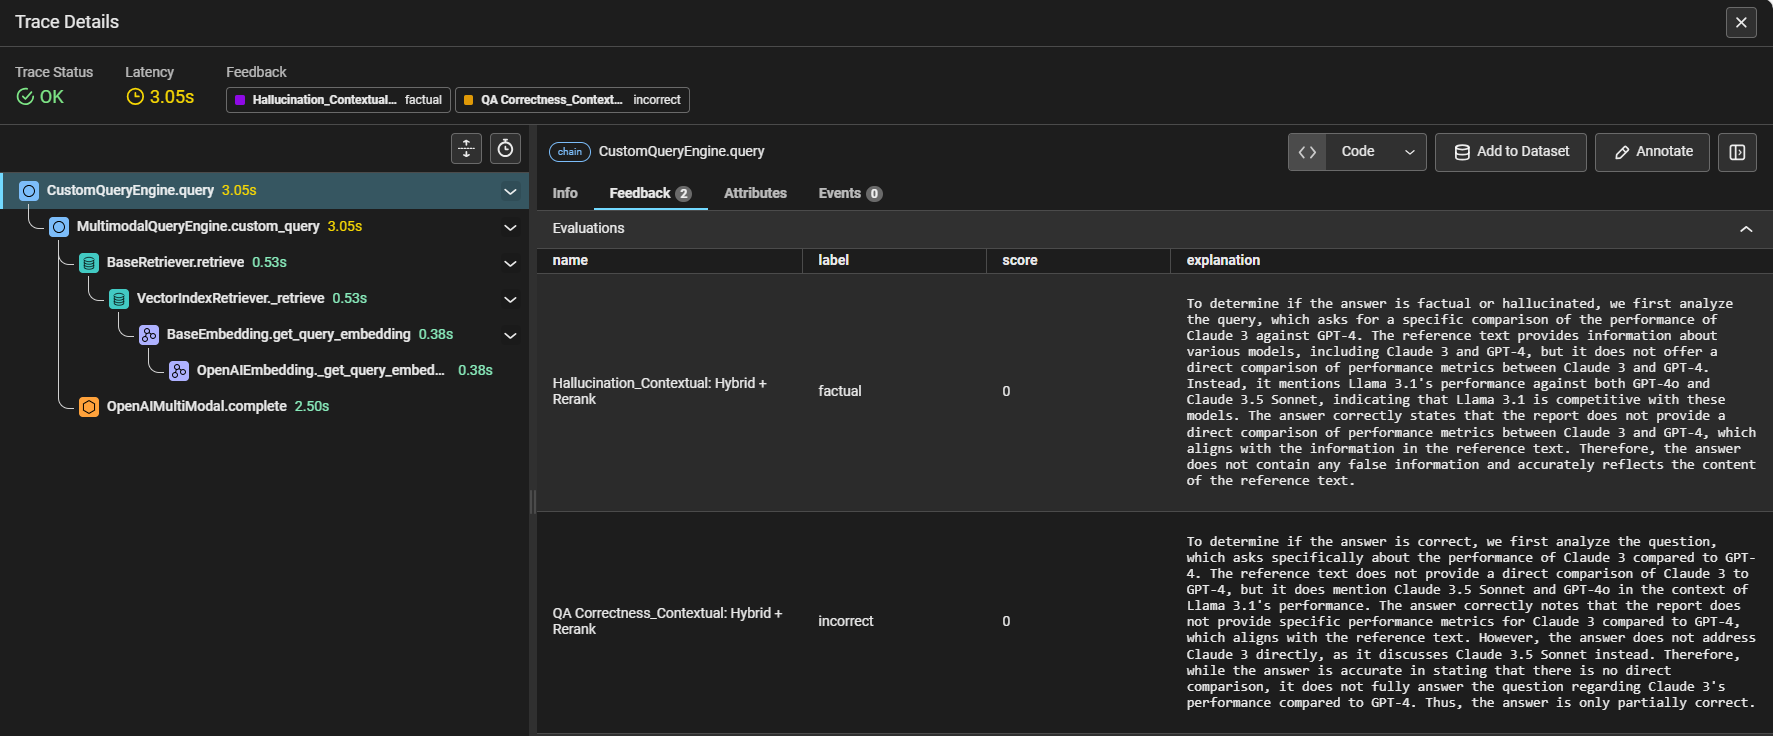

And for Standard: Embedding:
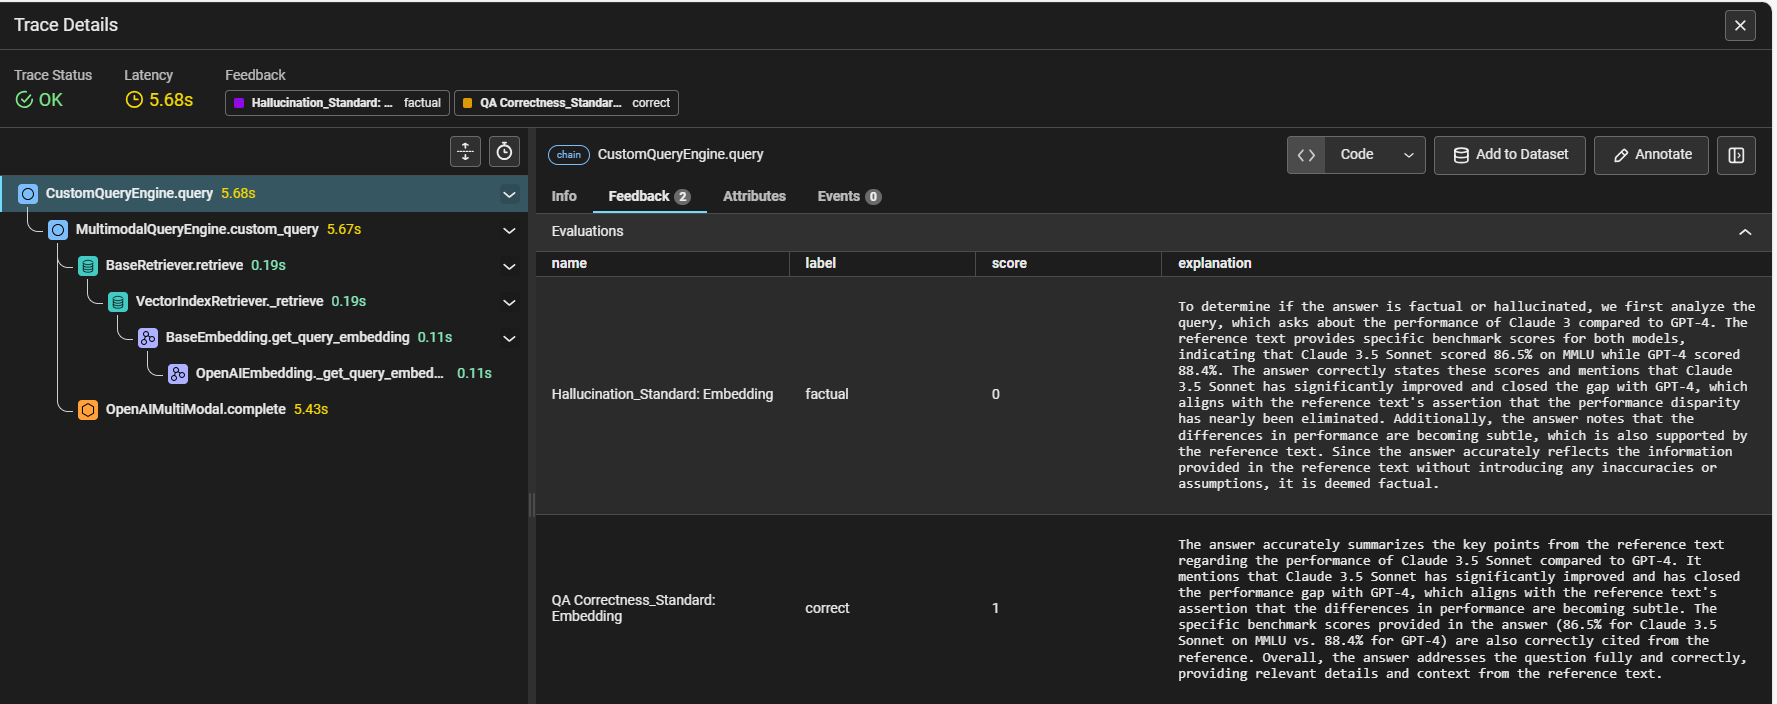

Now let's take a look at the the LLM input and output for Standard: Embedding:

##### Contextual: Hybrid + Rerank LLM Input
```json
{
  "kwargs": {
    "prompt": "Below we give parsed text from slides in parsed markdown format, as well as the image.\n\n---------------------\npage_num: 17\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_17.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions #stateofai |\n\n📝 → 📝\n\n## Is contamination inflating progress?\n\nWith new model families reporting incredibly strong benchmark performance straight out-of-the-gate, researchers have increasingly been shining a light on dataset contamination: when test or validation data leaks into the training set. Researchers from Scale retested a number of models on a new Grade School Math 1000 (GSM1k) that mirrors the style and complexity of the established GSM8k benchmark, finding significant performance drops in some cases. Similarly, researchers at X.ai re-evaluated models using a dataset based on the Hungarian national finals math exam that post-dated their release, with similar results.\n\n### Notable Models\n\n| Model | Gap Between GSM8k and GSM1k (%) |\n|-------|----------------------------------|\n| Mistral | -10 |\n| Phi | -9 |\n| Llama | -6 |\n| Gemma | -5 |\n| GPT | -2 |\n| Claude | 2 |\n\n### Exam Score vs GSM8k Performance of Various Models\n\n| Model | Exam Score (%) | GSM8k Score (%) |\n|-------|----------------|------------------|\n| Code Llama 7B | 10 | 12 |\n| Code Llama 34B | 20 | 30 |\n| Mistral 7B | 25 | 40 |\n| Llamma 7B | 28 | 35 |\n| Qwen 7B | 30 | 52 |\n| MetaMath 7B | 35 | 68 |\n| Llamma 34B | 40 | 55 |\n| GPT-3.5 Turbo | 45 | 57 |\n| Grok-0 (33B) | 48 | 58 |\n| MetaMath Mistral 7B | 60 | 80 |\n| OpenChat 3.5 | 65 | 82 |\n| Grok-1 | 68 | 63 |\n| Claude 2 | 68 | 88 |\n| GPT-4 | 70 | 92 |\n\nNote: The graph shows two distinct groups:\n1. \"Likely/known trained on GSM8k\" (red area): includes models like MetaMath Mistral 7B, OpenChat 3.5, MetaMath 7B, and Qwen 7B.\n2. \"Pretrained\" (green area): includes models like Grok-1, GPT-3.5 Turbo, Llamma 34B, Mistral 7B, and Code Llama models.\n\nThe graph suggests that models likely trained on GSM8k tend to perform better on the GSM8k benchmark but may not generalize as well to other exams. Pretrained models show a more consistent relationship between exam scores and GSM8k performance.\n\nscale.ai stateofai\ncontext: assistant: This chunk discusses the issue of dataset contamination in AI model training, specifically highlighting how the leakage of test or validation data into training sets can inflate reported performance metrics. It includes findings from researchers who tested various models on new benchmarks, revealing significant performance drops and providing comparative data on model scores. This section is part of the \"Research\" section in the \"State of AI Report 2024,\" which examines advancements and challenges in AI research.\n\nIntroduction | Research | Industry | Politics | Safety | Predictions #stateofai |\n\n📝 → 📝\n\n## Is contamination inflating progress?\n\nWith new model families reporting incredibly strong benchmark performance straight out-of-the-gate, researchers have increasingly been shining a light on dataset contamination: when test or validation data leaks into the training set. Researchers from Scale retested a number of models on a new Grade School Math 1000 (GSM1k) that mirrors the style and complexity of the established GSM8k benchmark, finding significant performance drops in some cases. Similarly, researchers at X.ai re-evaluated models using a dataset based on the Hungarian national finals math exam that post-dated their release, with similar results.\n\n### Notable Models\n\n| Model | Gap Between GSM8k and GSM1k (%) |\n|-------|----------------------------------|\n| Mistral | -10 |\n| Phi | -9 |\n| Llama | -6 |\n| Gemma | -5 |\n| GPT | -2 |\n| Claude | 2 |\n\n### Exam Score vs GSM8k Performance of Various Models\n\n| Model | Exam Score (%) | GSM8k Score (%) |\n|-------|----------------|------------------|\n| Code Llama 7B | 10 | 12 |\n| Code Llama 34B | 20 | 30 |\n| Mistral 7B | 25 | 40 |\n| Llamma 7B | 28 | 35 |\n| Qwen 7B | 30 | 52 |\n| MetaMath 7B | 35 | 68 |\n| Llamma 34B | 40 | 55 |\n| GPT-3.5 Turbo | 45 | 57 |\n| Grok-0 (33B) | 48 | 58 |\n| MetaMath Mistral 7B | 60 | 80 |\n| OpenChat 3.5 | 65 | 82 |\n| Grok-1 | 68 | 63 |\n| Claude 2 | 68 | 88 |\n| GPT-4 | 70 | 92 |\n\nNote: The graph shows two distinct groups:\n1. \"Likely/known trained on GSM8k\" (red area): includes models like MetaMath Mistral 7B, OpenChat 3.5, MetaMath 7B, and Qwen 7B.\n2. \"Pretrained\" (green area): includes models like Grok-1, GPT-3.5 Turbo, Llamma 34B, Mistral 7B, and Code Llama models.\n\nThe graph suggests that models likely trained on GSM8k tend to perform better on the GSM8k benchmark but may not generalize as well to other exams. Pretrained models show a more consistent relationship between exam scores and GSM8k performance.\n\nscale.ai stateofai\n\npage_num: 15\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_15.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n→ 📝\n\n## Llama 3 closes the gap between open and closed models\n\nIn April, Meta dropped the Llama 3 family, 3.1 in July, and 3.2 in September. Llama 3.1 405B, their largest to-date, is able to hold its own against GPT-4o and Claude 3.5 Sonnet across reasoning, math, multilingual, and long-context tasks. This marks the first time an open model has closed the gap with the proprietary frontier.\n\n- Meta stuck to the same decoder-only transformer architecture that it's used since Llama 1, with minor adaptations, namely more transformer layers and attention heads.\n- Meta used an incredible 15T tokens to train the family. While this blew through the \"Chinchilla-optimal\" amount of training compute, they found that both the 8B and 70B models improved log-linearly up to 15T.\n- Llama 3.1 405B was trained over 16,000 H100 GPUs, the first Llama model trained at this scale.\n- Meta followed up with Llama 3.2 in September, which incorporated 11B and 90B VLMs (Llama's multimodal debut). The former was competitive with Claude 3 Haiku, the latter with GPT-4o-mini. The company also released 1B and 3B text-only models, designed to operate on-device.\n- Llama-based models have now racked up over 440M\n\n### Llama 3.1 405B Human Evaluation\n\n| Model Comparison | Win | Tie | Loss |\n|------------------|-----|-----|------|\n| Llama 3.1 405B vs GPT-4-0125-Preview | 23.3% | 52.2% | 24.5% |\n| Llama 3.1 405B vs GPT-4o | 19.1% | 51.7% | 29.2% |\n| Llama 3.1 405B vs Claude 3.5 Sonnet | 24.9% | 50.8% | 24.2% |\n\nstateof.ai\ncontext: assistant: This chunk is part of the \"Research\" section in the \"State of AI Report 2024,\" discussing the advancements of Meta's Llama 3 family of models, particularly Llama 3.1 405B, and its competitive performance against proprietary models like GPT-4o and Claude 3.5 Sonnet. It highlights the significance of these developments in closing the gap between open and closed models in AI.\n\nIntroduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n→ 📝\n\n## Llama 3 closes the gap between open and closed models\n\nIn April, Meta dropped the Llama 3 family, 3.1 in July, and 3.2 in September. Llama 3.1 405B, their largest to-date, is able to hold its own against GPT-4o and Claude 3.5 Sonnet across reasoning, math, multilingual, and long-context tasks. This marks the first time an open model has closed the gap with the proprietary frontier.\n\n- Meta stuck to the same decoder-only transformer architecture that it's used since Llama 1, with minor adaptations, namely more transformer layers and attention heads.\n- Meta used an incredible 15T tokens to train the family. While this blew through the \"Chinchilla-optimal\" amount of training compute, they found that both the 8B and 70B models improved log-linearly up to 15T.\n- Llama 3.1 405B was trained over 16,000 H100 GPUs, the first Llama model trained at this scale.\n- Meta followed up with Llama 3.2 in September, which incorporated 11B and 90B VLMs (Llama's multimodal debut). The former was competitive with Claude 3 Haiku, the latter with GPT-4o-mini. The company also released 1B and 3B text-only models, designed to operate on-device.\n- Llama-based models have now racked up over 440M\n\n### Llama 3.1 405B Human Evaluation\n\n| Model Comparison | Win | Tie | Loss |\n|------------------|-----|-----|------|\n| Llama 3.1 405B vs GPT-4-0125-Preview | 23.3% | 52.2% | 24.5% |\n| Llama 3.1 405B vs GPT-4o | 19.1% | 51.7% | 29.2% |\n| Llama 3.1 405B vs Claude 3.5 Sonnet | 24.9% | 50.8% | 24.2% |\n\nstateof.ai\n\npage_num: 29\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_29.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions\n\n#stateofai |\n\n📝 → 📝\n\n## Synthetic data starts gaining more widespread adoption...\n\nLast year's report pointed to the divides of opinion around synthetic data: with some finding it useful, others fearing its potential to trigger model collapse by compounding errors. Opinion seems to be warming.\n\n- As well as being the main source of training data for the Phi family, synthetic data was used by Anthropic when training Claude 3 to help represent scenarios that might have been missing in the training data.\n\n- Hugging Face used Mixtral-8x7B Instruct to generate over 30M files and 25B tokens of synthetic textbooks, blog posts, and stories to recreate the Phi-1.5 training dataset, which they dubbed Cosmopedia.\n\n- To make this process easier, NVIDIA released the Nemotron-4-340B family, a suite of models designed specifically for synthetic data generation, available via a permissive license.\n\n- Meta's Llama can also be used for synthetic data generation. It also appears possible to create synthetic high-quality instruction data by extracting it directly from an aligned LLM, with techniques like Magpie. Models fine-tuned this way sometimes perform comparably to Llama-3-8B-Instruct.\n\n| Developer | Human Gen for Train Data | Nemotron-3-34B | Synthetic Response Data |\n|-----------|--------------------------|-----------------|--------------------------|\n| ✓         | ✓                        | ✓               | ✓                        |\n\n| Nemo Aligner | Synthetic Dataset Filter | Filter Synthetic Response Data | Nemotron-3-34B | Reward |\n|--------------|--------------------------|--------------------------------|-----------------|--------|\n| ✓            | ✓                        | ✓                              | ✓               | ✓      |\n\n| Model | SFT | RLHF | DOLL | RRHF | RLAIF | RLAIF+ | RLAIF++ | InCon | DPO |\n|-------|-----|------|------|------|-------|--------|---------|-------|-----|\n| ✓     | ✓   | ✓    | ✓    | ✓    | ✓     | ✓      | ✓       | ✓     | ✓   |\n\nstateofai\ncontext: assistant: This chunk is part of the \"Research\" section in the \"State of AI Report 2024,\" discussing the increasing adoption of synthetic data in AI training, its applications, and the evolving opinions surrounding its use. It highlights contributions from various organizations, including Anthropic, Hugging Face, NVIDIA, and Meta, in generating and utilizing synthetic data for model training.\n\nIntroduction | Research | Industry | Politics | Safety | Predictions\n\n#stateofai |\n\n📝 → 📝\n\n## Synthetic data starts gaining more widespread adoption...\n\nLast year's report pointed to the divides of opinion around synthetic data: with some finding it useful, others fearing its potential to trigger model collapse by compounding errors. Opinion seems to be warming.\n\n- As well as being the main source of training data for the Phi family, synthetic data was used by Anthropic when training Claude 3 to help represent scenarios that might have been missing in the training data.\n\n- Hugging Face used Mixtral-8x7B Instruct to generate over 30M files and 25B tokens of synthetic textbooks, blog posts, and stories to recreate the Phi-1.5 training dataset, which they dubbed Cosmopedia.\n\n- To make this process easier, NVIDIA released the Nemotron-4-340B family, a suite of models designed specifically for synthetic data generation, available via a permissive license.\n\n- Meta's Llama can also be used for synthetic data generation. It also appears possible to create synthetic high-quality instruction data by extracting it directly from an aligned LLM, with techniques like Magpie. Models fine-tuned this way sometimes perform comparably to Llama-3-8B-Instruct.\n\n| Developer | Human Gen for Train Data | Nemotron-3-34B | Synthetic Response Data |\n|-----------|--------------------------|-----------------|--------------------------|\n| ✓         | ✓                        | ✓               | ✓                        |\n\n| Nemo Aligner | Synthetic Dataset Filter | Filter Synthetic Response Data | Nemotron-3-34B | Reward |\n|--------------|--------------------------|--------------------------------|-----------------|--------|\n| ✓            | ✓                        | ✓                              | ✓               | ✓      |\n\n| Model | SFT | RLHF | DOLL | RRHF | RLAIF | RLAIF+ | RLAIF++ | InCon | DPO |\n|-------|-----|------|------|------|-------|--------|---------|-------|-----|\n| ✓     | ✓   | ✓    | ✓    | ✓    | ✓     | ✓      | ✓       | ✓     | ✓   |\n\nstateofai\n---------------------\nGiven the context information and not prior knowledge, answer the query. Explain whether you got the answer\nfrom the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.\n\nQuery: What does the report specifically say about the performance of Claude 3 compared to GPT-4?\nAnswer: ",
    "image_documents": [
      "<ImageNode(id_=2377983f-365c-4e77-824e-b9d553624be7)>",
      "<ImageNode(id_=d816ed9f-a045-4bc9-bfbe-4a9eb14adf82)>",
      "<ImageNode(id_=4f3c5b3c-6e1c-4acc-9637-7c3b7c6d7a85)>"
    ]
  }
}
```

##### Contextual: Hybrid + Rerank LLM Output: 
```plaintext
The report states that Llama 3.1 405B is able to hold its own against GPT-4o and Claude 3.5 Sonnet across various tasks, indicating that it performs competitively with these proprietary models. However, it does not provide a direct comparison of performance metrics between Claude 3 and GPT-4.

This information was derived from the parsed markdown text, specifically from the section discussing Llama 3's performance. There are no discrepancies between the parsed markdown and the context provided, as the markdown clearly outlines the competitive standing of Llama 3.1 against both GPT-4o and Claude 3.5 Sonnet without detailing specific performance metrics for Claude 3 compared to GPT-4.
```

STandard: Embedding LLM Input
```json
{
  "kwargs": {
    "prompt": "Below we give parsed text from slides in parsed markdown format, as well as the image.\n\n---------------------\npage_num: 12\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_12.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n📝 → 📝\n\n# OpenAI's reign of terror came to an end, until...\n\nFor much of the year, both benchmarks and community leaderboards pointed to a chasm between GPT-4 and 'the best of the rest'. However, Claude 3.5 Sonnet, Gemini 1.5, and Grok 2 have all but eliminated this gap as model performance now begin to converge.\n\n- On both formal benchmarks and vibes-based analysis, the best-funded frontier labs are able to rack up scores within low single digits of each other on individual capabilities.\n\n- Models are now consistently highly capable coders, are strong at factual recall and math, but less good at open-ended question-answering and multi-modal problem solving.\n\n- Many of the variations are sufficiently small that they are now likely to be the product of differences in implementation. For example, GPT-4o outperforms Claude 3.5 Sonnet on MMLU, but apparently underperforms it on MMLU-Pro - a benchmark designed to be more challenging.\n\n- Considering the relatively subtle technical differences between architectures and likely heavy overlaps in pre-training data, model builders are now increasingly having to compete on new capabilities\n\n| Claude 3.5 Sonnet benchmarks | Claude 3.5 Sonnet | Claude 2 | GPT-4 | Gemini 1.5 Pro | GPT-3.5 Turbo |\n|------------------------------|-------------------|----------|-------|-----------------|---------------|\n| MMLU                         | 86.5%             | 78.5%    | 88.4% | 85.9%           | 70.0%         |\n| GSM8K                        | 90.3%             | 81.8%    | 92.0% | 94.4%           | 57.1%         |\n| HumanEval                    | 91.0%             | 64.9%    | 84.1% | 84.1%           | 50.2%         |\n| MATH                         | 57.5%             | 37.5%    | -     | 53.2%           | 37.7%         |\n| BBH                          | 87.7%             | 75.5%    | 86.7% | 83.6%           | 70.1%         |\n| TruthfulQA                   | 71.4%             | 60.8%    | 59.3% | 64.1%           | 48.6%         |\n| Hellaswag                    | 93.1%             | 88.1%    | 95.4% | 87.8%           | 85.5%         |\n| MMLU-Pro                     | 71.1%             | 60.1%    | 70.9% | 67.7%           | 37.8%         |\n| Graded code quality          | 96.4%             | 78.5%    | -     | 90.8%           | 64.1%         |\n\nstateofai\n\nIntroduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n📝 → 📝\n\n# OpenAI's reign of terror came to an end, until...\n\nFor much of the year, both benchmarks and community leaderboards pointed to a chasm between GPT-4 and 'the best of the rest'. However, Claude 3.5 Sonnet, Gemini 1.5, and Grok 2 have all but eliminated this gap as model performance now begin to converge.\n\n- On both formal benchmarks and vibes-based analysis, the best-funded frontier labs are able to rack up scores within low single digits of each other on individual capabilities.\n\n- Models are now consistently highly capable coders, are strong at factual recall and math, but less good at open-ended question-answering and multi-modal problem solving.\n\n- Many of the variations are sufficiently small that they are now likely to be the product of differences in implementation. For example, GPT-4o outperforms Claude 3.5 Sonnet on MMLU, but apparently underperforms it on MMLU-Pro - a benchmark designed to be more challenging.\n\n- Considering the relatively subtle technical differences between architectures and likely heavy overlaps in pre-training data, model builders are now increasingly having to compete on new capabilities\n\n| Claude 3.5 Sonnet benchmarks | Claude 3.5 Sonnet | Claude 2 | GPT-4 | Gemini 1.5 Pro | GPT-3.5 Turbo |\n|------------------------------|-------------------|----------|-------|-----------------|---------------|\n| MMLU                         | 86.5%             | 78.5%    | 88.4% | 85.9%           | 70.0%         |\n| GSM8K                        | 90.3%             | 81.8%    | 92.0% | 94.4%           | 57.1%         |\n| HumanEval                    | 91.0%             | 64.9%    | 84.1% | 84.1%           | 50.2%         |\n| MATH                         | 57.5%             | 37.5%    | -     | 53.2%           | 37.7%         |\n| BBH                          | 87.7%             | 75.5%    | 86.7% | 83.6%           | 70.1%         |\n| TruthfulQA                   | 71.4%             | 60.8%    | 59.3% | 64.1%           | 48.6%         |\n| Hellaswag                    | 93.1%             | 88.1%    | 95.4% | 87.8%           | 85.5%         |\n| MMLU-Pro                     | 71.1%             | 60.1%    | 70.9% | 67.7%           | 37.8%         |\n| Graded code quality          | 96.4%             | 78.5%    | -     | 90.8%           | 64.1%         |\n\nstateofai\n\npage_num: 19\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_19.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n📝 → 📝\n\n# Live by the vibes, die by the vibes...or close your eyes for a year and OpenAI is still #1\n\nThe LMSYS Chatbot Arena Leaderboard has emerged as the community's favorite method of formalizing evaluation by \"vibes\". But as model performance improves, it's beginning to produce counterintuitive results.\n\n- The arena, which allows users to interact with two randomly selected chatbots side-by-side provides a rough crowdsourced evaluation.\n\n- However, controversially, this led to GPT-4o and GPT-4o Mini receiving the same scores, with the latter also outperforming Claude Sonnet 3.5.\n\n- This has led to concerns that the ranking is essentially becoming a way of assessing which writing style users happen to prefer most.\n\n- Additionally, as smaller models tend to perform less well on tasks involving more tokens, the 8k context limit arguably gives them an unfair advantage.\n\n- However, the early version of the vision leaderboard is now beginning to gain traction and aligns better with other evals.\n\nFigure 1: Confidence Intervals on Model Strength (via Bootstrapping)\n\n| Model | Rating |\n|-------|--------|\n| GPT-4o-mini | ~1280 |\n| GPT-4o | ~1280 |\n| Claude-2.1 | ~1270 |\n| GPT-4 | ~1265 |\n| Claude-2.0 | ~1260 |\n| GPT-4-0613 | ~1255 |\n| GPT-4-0314 | ~1250 |\n| Claude-instant-1.2 | ~1245 |\n| Gemini-Pro | ~1240 |\n| Claude-1.3 | ~1235 |\n| Claude-1.2 | ~1230 |\n| ChatGPT-3.5-Turbo | ~1225 |\n| Vicuna-v1.5-13b | ~1215 |\n| Llama-2-70b-chat | ~1210 |\n| Claude-instant-1.0 | ~1205 |\n| Llama-2-13b-chat | ~1200 |\n| Vicuna-v1.5-7b | ~1195 |\n| ChatGPT-3.5-0301 | ~1190 |\n| Alpaca-7B | ~1185 |\n\nNote: The graph shows confidence intervals for various AI models, with GPT-4o mini and GPT-4o jointly ranked #1 overall.\n\nstateofai\n\nIntroduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n📝 → 📝\n\n# Live by the vibes, die by the vibes...or close your eyes for a year and OpenAI is still #1\n\nThe LMSYS Chatbot Arena Leaderboard has emerged as the community's favorite method of formalizing evaluation by \"vibes\". But as model performance improves, it's beginning to produce counterintuitive results.\n\n- The arena, which allows users to interact with two randomly selected chatbots side-by-side provides a rough crowdsourced evaluation.\n\n- However, controversially, this led to GPT-4o and GPT-4o Mini receiving the same scores, with the latter also outperforming Claude Sonnet 3.5.\n\n- This has led to concerns that the ranking is essentially becoming a way of assessing which writing style users happen to prefer most.\n\n- Additionally, as smaller models tend to perform less well on tasks involving more tokens, the 8k context limit arguably gives them an unfair advantage.\n\n- However, the early version of the vision leaderboard is now beginning to gain traction and aligns better with other evals.\n\nFigure 1: Confidence Intervals on Model Strength (via Bootstrapping)\n\n| Model | Rating |\n|-------|--------|\n| GPT-4o-mini | ~1280 |\n| GPT-4o | ~1280 |\n| Claude-2.1 | ~1270 |\n| GPT-4 | ~1265 |\n| Claude-2.0 | ~1260 |\n| GPT-4-0613 | ~1255 |\n| GPT-4-0314 | ~1250 |\n| Claude-instant-1.2 | ~1245 |\n| Gemini-Pro | ~1240 |\n| Claude-1.3 | ~1235 |\n| Claude-1.2 | ~1230 |\n| ChatGPT-3.5-Turbo | ~1225 |\n| Vicuna-v1.5-13b | ~1215 |\n| Llama-2-70b-chat | ~1210 |\n| Claude-instant-1.0 | ~1205 |\n| Llama-2-13b-chat | ~1200 |\n| Vicuna-v1.5-7b | ~1195 |\n| ChatGPT-3.5-0301 | ~1190 |\n| Alpaca-7B | ~1185 |\n\nNote: The graph shows confidence intervals for various AI models, with GPT-4o mini and GPT-4o jointly ranked #1 overall.\n\nstateofai\n\npage_num: 15\nimage_path: data_images_state_of_ai_report_2024\\58f8dea9-e908-4db0-82dc-f1747fc8abb3-page_15.jpg\nparsed_text_markdown: Introduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n→ 📝\n\n## Llama 3 closes the gap between open and closed models\n\nIn April, Meta dropped the Llama 3 family, 3.1 in July, and 3.2 in September. Llama 3.1 405B, their largest to-date, is able to hold its own against GPT-4o and Claude 3.5 Sonnet across reasoning, math, multilingual, and long-context tasks. This marks the first time an open model has closed the gap with the proprietary frontier.\n\n- Meta stuck to the same decoder-only transformer architecture that it's used since Llama 1, with minor adaptations, namely more transformer layers and attention heads.\n- Meta used an incredible 15T tokens to train the family. While this blew through the \"Chinchilla-optimal\" amount of training compute, they found that both the 8B and 70B models improved log-linearly up to 15T.\n- Llama 3.1 405B was trained over 16,000 H100 GPUs, the first Llama model trained at this scale.\n- Meta followed up with Llama 3.2 in September, which incorporated 11B and 90B VLMs (Llama's multimodal debut). The former was competitive with Claude 3 Haiku, the latter with GPT-4o-mini. The company also released 1B and 3B text-only models, designed to operate on-device.\n- Llama-based models have now racked up over 440M\n\n### Llama 3.1 405B Human Evaluation\n\n| Model Comparison | Win | Tie | Loss |\n|------------------|-----|-----|------|\n| Llama 3.1 405B vs GPT-4-0125-Preview | 23.3% | 52.2% | 24.5% |\n| Llama 3.1 405B vs GPT-4o | 19.1% | 51.7% | 29.2% |\n| Llama 3.1 405B vs Claude 3.5 Sonnet | 24.9% | 50.8% | 24.2% |\n\nstateof.ai\n\nIntroduction | Research | Industry | Politics | Safety | Predictions\n#stateofai |\n\n→ 📝\n\n## Llama 3 closes the gap between open and closed models\n\nIn April, Meta dropped the Llama 3 family, 3.1 in July, and 3.2 in September. Llama 3.1 405B, their largest to-date, is able to hold its own against GPT-4o and Claude 3.5 Sonnet across reasoning, math, multilingual, and long-context tasks. This marks the first time an open model has closed the gap with the proprietary frontier.\n\n- Meta stuck to the same decoder-only transformer architecture that it's used since Llama 1, with minor adaptations, namely more transformer layers and attention heads.\n- Meta used an incredible 15T tokens to train the family. While this blew through the \"Chinchilla-optimal\" amount of training compute, they found that both the 8B and 70B models improved log-linearly up to 15T.\n- Llama 3.1 405B was trained over 16,000 H100 GPUs, the first Llama model trained at this scale.\n- Meta followed up with Llama 3.2 in September, which incorporated 11B and 90B VLMs (Llama's multimodal debut). The former was competitive with Claude 3 Haiku, the latter with GPT-4o-mini. The company also released 1B and 3B text-only models, designed to operate on-device.\n- Llama-based models have now racked up over 440M\n\n### Llama 3.1 405B Human Evaluation\n\n| Model Comparison | Win | Tie | Loss |\n|------------------|-----|-----|------|\n| Llama 3.1 405B vs GPT-4-0125-Preview | 23.3% | 52.2% | 24.5% |\n| Llama 3.1 405B vs GPT-4o | 19.1% | 51.7% | 29.2% |\n| Llama 3.1 405B vs Claude 3.5 Sonnet | 24.9% | 50.8% | 24.2% |\n\nstateof.ai\n---------------------\nGiven the context information and not prior knowledge, answer the query. Explain whether you got the answer\nfrom the parsed markdown or raw text or image, and if there's discrepancies, and your reasoning for the final answer.\n\nQuery: What does the report specifically say about the performance of Claude 3 compared to GPT-4?\nAnswer: ",
    "image_documents": [
      "<ImageNode(id_=bb94af25-acdd-48dd-b1ff-18fe69135683)>",
      "<ImageNode(id_=75d78b27-3974-4ec6-a9d3-c031221f4283)>",
      "<ImageNode(id_=2e69818a-8ab5-4e36-9b29-ab3c1d50ba05)>"
    ]
  }
}
```

Standard: Embedding LLM Output:
```plaintext
The report indicates that Claude 3.5 Sonnet has significantly improved its performance, closing the gap with GPT-4. Specifically, it mentions that Claude 3.5 Sonnet, along with other models like Gemini 1.5 and Grok 2, has nearly eliminated the performance disparity that previously existed between GPT-4 and other models.

In the benchmarks provided, Claude 3.5 Sonnet scored 86.5% on MMLU compared to GPT-4's 88.4%, and it performed competitively in other areas as well, such as HumanEval (91.0% for Claude 3.5 Sonnet vs. 84.1% for GPT-4).

Additionally, the report notes that the differences in performance are becoming increasingly subtle, suggesting that model builders are now competing on new capabilities rather than just raw performance metrics.

This information was derived from the parsed markdown text, specifically from the sections discussing the performance benchmarks of Claude 3.5 Sonnet and GPT-4. There are no discrepancies between the parsed markdown and the context provided in the query.
```
